# How I created fire_data_clean_withacres.csv

In [1]:
#Imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

from sklearn.svm import SVC

In [4]:
# https://www.fire.ca.gov/incidents/
fire_df = pd.read_csv('./data/fire.csv')

In [6]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   incident_name                     1728 non-null   object 
 1   incident_is_final                 1728 non-null   bool   
 2   incident_date_last_update         1728 non-null   object 
 3   incident_date_created             1728 non-null   object 
 4   incident_administrative_unit      1720 non-null   object 
 5   incident_administrative_unit_url  0 non-null      float64
 6   incident_county                   1717 non-null   object 
 7   incident_location                 1728 non-null   object 
 8   incident_acres_burned             1728 non-null   int64  
 9   incident_containment              1728 non-null   int64  
 10  incident_control                  116 non-null    object 
 11  incident_cooperating_agencies     1486 non-null   object 
 12  incide

In [8]:
fire_df['incident_is_final'].unique()

array([ True, False])

In [29]:
# radius of circle can be determined from this number
fire_df['incident_acres_burned'].unique()

array([    37,    122,    406,     30,    274,   6965,     75,    125,
         3166,    354,    217,    510,   4346,     40,    712,     91,
           35,     25,     90,    303,    100,   2781,     50,    124,
         1271,   1984,    149,    170,    500,    298,      0,     28,
        30274,    240,     42,     60,     96,    108,   1708,    237,
          482,     46,    150,    534,    105,    492,    754,    502,
          200,     38,   7055,     85,     73,     43,    572,  27531,
        22992,  14754,     92,    612,     45,    195,    158,    163,
           15,     31,   1070,   1383,  20292,  12503,    116,    243,
           27,   2462,  27440,     97,     70,    110,   8073,    513,
          794,    196,  11429,    413,   2060,     41,   3111,    134,
          268,     52,     80,     68, 257314,    263,     94,     98,
          376,    159,   2236,    305,     33,     51,    120,    190,
           64,     82,   3505,     23,    865,   1952,    333,    106,
      

In [31]:
fire_df['incident_longitude'].unique()

array([-122.309   ,    1.      , -118.01651 , ..., -117.65719 ,
       -120.488892, -117.675067])

In [32]:
fire_df['incident_latitude'].unique()

array([40.774   ,  1.      , 36.602575, ..., 33.73614 , 39.009454,
       33.877257])

In [30]:
#need to drop flood columns
fire_df['incident_type'].unique()

array([nan, 'Wildfire', 'Flood'], dtype=object)

In [33]:
# when you click on it, give a warnign message saying it's active
# Or have the circle be pulsing or something
fire_df['is_active'].unique()

array(['N', 'Y'], dtype=object)

In [42]:
df_test = fire_df.loc[(fire_df['incident_is_final'] == False) & (fire_df['is_active'] == 'Y')]
df_test.head()

,incident_name,incident_is_final,incident_date_last_update,incident_date_created,incident_administrative_unit,incident_administrative_unit_url,incident_county,incident_location,incident_acres_burned,incident_containment,...,incident_latitude,incident_type,incident_id,incident_url,incident_date_extinguished,incident_dateonly_extinguished,incident_dateonly_created,is_active,calfire_incident,notification_desired
1619,Apple Fire,False,2020-10-15 10:26:55,2020-07-31 18:08:39,"Unified Command: USFS - San Bernardino, and Yu...",NaN,Riverside,"off of Oak Glen Road and Apple Tree Lane, Nort...",0,0,...,33.99139,Wildfire,8b9ae457-96ea-4041-912c-6b33e8498d98,https://www.fire.ca.gov/incidents/2020/7/31/ap...,NaN,NaN,2020-07-31,Y,False,False
1653,August Complex (includes Doe Fire),False,2020-10-22 10:48:34,2020-08-16 20:37:26,Mendocino National Forest,NaN,"Mendocino, Humboldt, Trinity, Tehama, Glenn, L...","Mendocino, Humboldt, Trinity, Tehama, Glenn, ...",0,0,...,39.77600,Wildfire,b8f267be-9911-44ee-8a73-7a0537fbd6fa,https://www.fire.ca.gov/incidents/2020/8/16/au...,NaN,NaN,2020-08-16,Y,False,False
1661,Red Salmon Complex,False,2020-08-18 09:49:34,2020-08-18 09:49:34,Shasta-Trinity National Forest,NaN,Humboldt,"near Salmon Mountain, Northeast of Willow Creek",0,0,...,41.16800,Wildfire,c1bf8f6d-2c85-4884-b866-1e9efa15917c,https://www.fire.ca.gov/incidents/2020/8/18/re...,NaN,NaN,2020-08-18,Y,False,False
1662,Blue Jay Fire,False,2020-09-22 12:47:56,2020-08-18 10:16:11,Yosemite National Forest,NaN,Mariposa,"Near Tioga Road, North of Yosemite Valley",0,0,...,37.84463,Wildfire,0b95310d-211e-4416-bd38-1a0b0106cd4a,https://www.fire.ca.gov/incidents/2020/8/18/bl...,NaN,NaN,2020-08-18,Y,False,False
1669,North Complex Fire,False,2020-10-05 07:12:04,2020-08-18 21:21:53,Plumas National Forest,NaN,"Plumas, Butte",Flemmings Sheep Camp,0,0,...,39.69072,Wildfire,48d8822a-b37b-4902-ad3d-9d988e54f643,https://www.fire.ca.gov/incidents/2020/8/18/no...,NaN,NaN,2020-08-18,Y,False,False


In [44]:
fire_df['incident_dateonly_extinguished'].unique()

array(['2018-01-09', '2009-05-25', '2013-02-28', '2013-04-22',
       '2013-05-01', '2013-05-09', '2013-05-03', '2013-05-04',
       '2013-05-05', '2013-05-15', '2013-05-21', '2013-05-17',
       '2013-05-18', '2013-05-20', '2013-05-30', '2013-05-23',
       '2013-05-26', '2013-05-25', '2013-05-31', '2013-05-29',
       '2013-06-03', '2013-06-02', '2013-06-09', '2013-06-14',
       '2013-06-05', '2013-06-06', '2013-06-08', '2013-06-13',
       '2013-06-26', '2013-06-15', '2013-06-18', '2013-06-19',
       '2013-06-25', '2013-06-20', '2013-07-01', '2013-06-29',
       '2013-07-04', '2013-07-05', '2013-07-06', '2013-07-15',
       '2013-07-07', '2013-07-08', '2013-07-09', '2013-07-11',
       '2013-07-12', '2013-07-13', '2013-07-30', '2013-08-03',
       '2013-07-26', '2013-07-28', '2013-09-24', '2013-08-31',
       '2013-08-04', '2013-07-17', '2013-07-25', '2013-07-23',
       '2013-07-22', '2013-07-19', '2013-07-20', '2013-08-14',
       '2013-08-09', '2013-08-08', '2013-08-07', '2013-

In [45]:
fire_df['incident_dateonly_created'].unique()

array(['2017-10-31', '2009-05-24', '2013-02-24', '2013-04-20',
       '2013-04-30', '2013-05-01', '2013-05-03', '2013-05-13',
       '2013-05-04', '2013-05-15', '2013-05-16', '2013-05-17',
       '2013-05-19', '2013-05-20', '2013-05-21', '2013-05-30',
       '2013-05-22', '2013-05-23', '2013-05-25', '2013-05-26',
       '2013-05-27', '2013-05-28', '2013-06-01', '2013-06-02',
       '2013-06-03', '2013-06-09', '2013-06-10', '2013-06-04',
       '2013-06-05', '2013-06-08', '2013-06-12', '2013-06-13',
       '2013-06-16', '2013-06-14', '2013-06-18', '2013-06-17',
       '2013-06-25', '2013-06-20', '2013-06-28', '2013-07-01',
       '2013-06-29', '2013-07-02', '2013-07-03', '2013-07-04',
       '2013-07-06', '2013-07-07', '2013-07-08', '2013-07-09',
       '2013-07-12', '2013-07-15', '2013-08-03', '2013-07-25',
       '2013-07-28', '2013-07-22', '2013-07-31', '2013-08-01',
       '2013-07-16', '2013-08-04', '2013-07-23', '2013-07-19',
       '2013-07-26', '2013-08-05', '2013-08-06', '2013-

In [65]:
df = fire_df.loc[fire_df['incident_type'] == 'Wildfire']

df = df[['incident_name',
         'incident_longitude', 
              'incident_latitude',
              'incident_is_final',
              'incident_acres_burned', 
              'is_active',
              'incident_dateonly_extinguished',
              'incident_dateonly_created'
             ]]

df.rename(columns = 
          {
              'y':'year',
              'incident_name': 'name',
              'incident_acres_burned': "acres_burned", 
              'incident_longitude': 'x', 
              'incident_latitude': 'y',
              'incident_dateonly_extinguished': 'extinguished_date',
              'incident_dateonly_created': 'created_date'
          
          }, inplace = True)

df['extinguished_date'] = pd.to_datetime(df['extinguished_date'])
df['created_date'] = pd.to_datetime(df['created_date'])

In [66]:
df.tail()

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date
1723,Dersch Fire,-122.181020,40.476460,True,133,N,NaT,2020-10-25
1724,Olinda Fire,-122.342000,40.414860,True,5,N,2020-10-25,2020-10-25
1725,Silverado Fire,-117.657190,33.736140,False,13354,Y,NaT,2020-10-26
1726,Point Fire (Placer County),-120.488892,39.009454,False,0,Y,NaT,2020-10-26
1727,Blue Ridge Fire,-117.675067,33.877257,False,14334,Y,NaT,2020-10-26


In [67]:
df_current = df.loc[df['incident_is_final'] == False]
df_current

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date
1603,July Complex,-121.477000,41.699000,False,0,N,NaT,2020-07-24
1609,Adams Fire,-120.025872,39.922415,False,0,N,NaT,2020-07-27
1617,Dam Fire,-117.889503,34.173630,False,0,N,NaT,2020-07-30
1619,Apple Fire,-116.961700,33.991390,False,0,Y,NaT,2020-07-31
1620,Cowhead Fire,-120.171830,41.522610,False,0,N,NaT,2020-07-31
1621,Stump Fire,-121.641500,40.346590,False,0,N,NaT,2020-08-01
1622,Castaic Fire,-118.596990,34.518530,False,0,N,NaT,2020-08-01
1632,166 Fire,-119.579500,34.934420,False,0,N,NaT,2020-08-03
1633,Trimmer Fire,-119.243900,36.909330,False,0,N,NaT,2020-08-04
1636,Texas Fire,-118.461150,-118.461150,False,0,N,NaT,2020-08-06


In [70]:
df_current_acres_burned = df_current.loc[df_current['acres_burned'] > 0]
df_current_acres_burned

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date
1644,Ranch 2 Fire,-117.910498,34.160265,False,4237,N,NaT,2020-08-13
1648,Whale Fire,-120.856731,35.472114,False,312,N,2020-08-19,2020-08-15
1657,Holser Fire,-118.758965,34.438759,False,3000,N,NaT,2020-08-17
1665,3-19 Fire,-123.013667,39.276000,False,62,N,2020-08-21,2020-08-18
1680,Placer Fire,-120.124330,35.433520,False,53,N,NaT,2020-08-25
1721,Pope Fire,-122.378280,38.561840,False,61,N,2020-10-25,2020-10-23
1725,Silverado Fire,-117.657190,33.736140,False,13354,Y,NaT,2020-10-26
1727,Blue Ridge Fire,-117.675067,33.877257,False,14334,Y,NaT,2020-10-26


In [72]:
df_burned_acres_and_in_year = df.loc[(df['acres_burned'] > 0) & (df['created_date'].dt.year == 2020)]
df_burned_acres_and_in_year

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date
1469,Bear Fire,-123.637841,40.511092,True,15,N,NaT,2020-02-15
1470,Antelope Fire,-120.329185,39.692300,True,102,N,2020-02-20,2020-02-17
1471,Beegum Fire,-122.847222,40.335833,True,75,N,2020-02-24,2020-02-23
1472,Wood Fire,-120.493920,40.621550,True,57,N,2020-02-23,2020-02-23
1473,Baseball Fire,-122.941111,39.756389,True,211,N,2020-03-03,2020-02-25
...,...,...,...,...,...,...,...,...
1722,Point Fire (Shasta and Tehama County),-122.390330,40.388690,True,275,N,NaT,2020-10-25
1723,Dersch Fire,-122.181020,40.476460,True,133,N,NaT,2020-10-25
1724,Olinda Fire,-122.342000,40.414860,True,5,N,2020-10-25,2020-10-25
1725,Silverado Fire,-117.657190,33.736140,False,13354,Y,NaT,2020-10-26


In [138]:
df_acres_burned_alltime = df.loc[(df['acres_burned'] > 0)]
df_acres_burned_alltime.head()

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date
1,Pala Fire,1.00000,1.00000,True,122,N,2009-05-25,2009-05-24
188,Sand Fire,-120.78190,38.56910,True,4240,N,2014-08-02,2014-07-25
840,Atlas Fire (Southern LNU Complex),-122.24367,38.39206,True,51624,N,2018-02-09,2017-10-08
841,Tubbs Fire (Central LNU Complex),-122.62879,38.60895,True,36807,N,2018-02-09,2017-10-08
842,Nuns / Adobe / Norrbom/ Pressley / Partrick Fi...,-122.52090,38.40410,True,56556,N,2018-02-09,2017-10-08


In [110]:
# https://stackoverflow.com/questions/53399137/pandas-issue-with-pandas-nat-when-changing-from-pandas-libs-tslib-nattype
isinstance(df_burned_acres_and_in_year['extinguished_date'].iloc[0],pd._libs.tslibs.nattype.NaTType)

True

In [139]:
my_str = []
for x in range(len(df_acres_burned_alltime['name'])):
    if (isinstance(df_acres_burned_alltime['extinguished_date'].iloc[x],pd._libs.tslibs.nattype.NaTType)) == True:
        
        if df_acres_burned_alltime['is_active'].iloc[x] == 'Y':
            # ongoing: extinguished_date = NaT AND is_active = Y
            my_str.append('ongoing')
            
        elif df_acres_burned_alltime['is_active'].iloc[x] == 'N':
            # contained: extinguished_date = NaT AND is_active = N
            my_str.append('contained')
    else:
        # extinguished: extinguished_date != NaT
        my_str.append('extinguished')
        
df_acres_burned_alltime['status'] = my_str

df_acres_burned_alltime.head()

<ipython-input-139-dd6d52f3d1f6>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acres_burned_alltime['status'] = my_str


,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date,status
1,Pala Fire,1.00000,1.00000,True,122,N,2009-05-25,2009-05-24,extinguished
188,Sand Fire,-120.78190,38.56910,True,4240,N,2014-08-02,2014-07-25,extinguished
840,Atlas Fire (Southern LNU Complex),-122.24367,38.39206,True,51624,N,2018-02-09,2017-10-08,extinguished
841,Tubbs Fire (Central LNU Complex),-122.62879,38.60895,True,36807,N,2018-02-09,2017-10-08,extinguished
842,Nuns / Adobe / Norrbom/ Pressley / Partrick Fi...,-122.52090,38.40410,True,56556,N,2018-02-09,2017-10-08,extinguished


In [143]:
# get all fires with status = contained or ongoing

df_still_concerning = df_acres_burned_alltime.loc[(df_acres_burned_alltime['status'] == 'ongoing') | (df_acres_burned_alltime['status'] == 'contained')]
df_still_concerning.head()

,name,x,y,incident_is_final,acres_burned,is_active,extinguished_date,created_date,status
1270,Far Fire,-121.350140,39.060660,True,38,N,NaT,2019-07-06,contained
1271,Lake Fire,-120.296551,37.524378,True,244,N,NaT,2019-07-08,contained
1278,Horse Fire,-122.435492,40.463936,True,30,N,NaT,2019-07-12,contained
1287,Whiskey Fire,-121.468074,37.962557,True,90,N,NaT,2019-07-16,contained
1292,Valley Fire,-120.027731,37.241427,True,149,N,NaT,2019-07-21,contained


In [141]:
df_still_concerning['created_date'].dt.year.min()
# so the fires that are still a concern only started within these last two years

2019

In [165]:
df_final_draft = df_still_concerning[['name', 'x', 'y', 'acres_burned', 'status']]

In [166]:
df_final_draft['radius'] = np.log(df_final_draft['acres_burned'])

<ipython-input-166-c9343968d811>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_draft['radius'] = np.log(df_final_draft['acres_burned'])


In [171]:
df_final_draft.head()

,name,x,y,acres_burned,status,radius
1270,Far Fire,-121.350140,39.060660,38,contained,3.637586
1271,Lake Fire,-120.296551,37.524378,244,contained,5.497168
1278,Horse Fire,-122.435492,40.463936,30,contained,3.401197
1287,Whiskey Fire,-121.468074,37.962557,90,contained,4.499810
1292,Valley Fire,-120.027731,37.241427,149,contained,5.003946


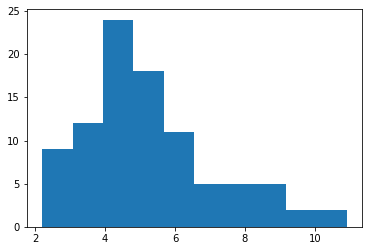

In [167]:
plt.hist(df_final_draft['radius']);

In [172]:
df_final = df_final_draft[['name', 'x', 'y', 'radius', 'acres_burned', 'status']]
df_final.head()

,name,x,y,radius,acres_burned,status
1270,Far Fire,-121.350140,39.060660,3.637586,38,contained
1271,Lake Fire,-120.296551,37.524378,5.497168,244,contained
1278,Horse Fire,-122.435492,40.463936,3.401197,30,contained
1287,Whiskey Fire,-121.468074,37.962557,4.499810,90,contained
1292,Valley Fire,-120.027731,37.241427,5.003946,149,contained


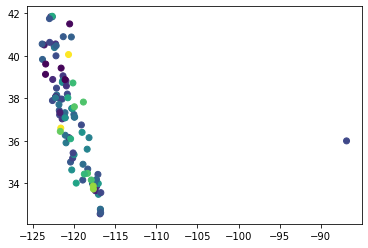

In [173]:
plt.scatter(x = df_final['x'], y = df_final['y'], c = df_final['radius'])

In [174]:
df_final.to_csv('./data/fire_data_clean_withacres.csv')

In [86]:
# if the extinguished_date is empty but the is_active is N, that means the fire is ongoing, but contained

#new column: 'contained', 'extinguished', 'ongoing' (will put as a pop up status)

fire_status = []

# ongoing: extinguished_date = NaT AND is_active = Y
# contained: extinguished_date = NaT AND is_active = N
df_extinguished_isnull = df_burned_acres_and_in_year[df_burned_acres_and_in_year['extinguished_date'].isnull()]
for x in range(len(df_extinguished_isnull['extinguished_date'])):
    
# extinguished: extinguished_date != NaT
type(df_extinguished_isnull['extinguished_date'])

pandas.core.series.Series

In [56]:
df_current = fire_df.loc[fire_df['incident_is_final'] == False]

In [57]:
df_past = fire_df.loc[fire_df['incident_is_final'] == True]
df_past['incident_date_extinguished'].head()
# make this column the datetime index
df_past['incident_date_extinguished'] = pd.to_datetime(df_past['incident_date_extinguished'])
df_past.set_index('incident_date_extinguished', inplace = True)
df_past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1688 entries, 2018-01-09 13:46:00 to 2020-10-25 07:07:00
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   incident_name                     1688 non-null   object 
 1   incident_is_final                 1688 non-null   bool   
 2   incident_date_last_update         1688 non-null   object 
 3   incident_date_created             1688 non-null   object 
 4   incident_administrative_unit      1682 non-null   object 
 5   incident_administrative_unit_url  0 non-null      float64
 6   incident_county                   1677 non-null   object 
 7   incident_location                 1688 non-null   object 
 8   incident_acres_burned             1688 non-null   int64  
 9   incident_containment              1688 non-null   int64  
 10  incident_control                  115 non-null    object 
 11  incident_cooperating_agencies    

<ipython-input-57-f32b4c48f5ad>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['incident_date_extinguished'] = pd.to_datetime(df_past['incident_date_extinguished'])


In [23]:
df_current['incident_date_last_update'].head()

1603    2020-08-13 10:54:18
1609    2020-08-17 11:05:08
1617    2020-08-13 11:21:23
1619    2020-10-15 10:26:55
1620    2020-08-17 11:05:49
Name: incident_date_last_update, dtype: object